In [1]:
import hashlib
import os
import torch
from IPython.core.display_functions import clear_output
from PIL import Image
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel
from tqdm import tqdm
import numpy as np

device = 'cuda:7'

2025-05-13 13:00:09.155925: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 13:00:09.173849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-13 13:00:09.195042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-13 13:00:09.201368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 13:00:09.219313: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def crop(image):
    image = np.array(image)

    mask = image > 5
    y_nonzero, x_nonzero, _ = np.where(mask)

    image = image[np.min(y_nonzero):np.max(y_nonzero) + 1, np.min(x_nonzero):np.max(x_nonzero) + 1]
    return Image.fromarray(image)

def image_hash(image):
    return hashlib.sha256(image.tobytes()).hexdigest()

def clear_dataset(path, output_path):
    filenames = os.listdir(path)
    hashes = set()
    dubles = 0
    big_crops = 0

    with tqdm(total=len(filenames)) as pbar:
        for filename in filenames:
            img = Image.open(os.path.join(path, filename))

            img_hash = image_hash(img)
            if img_hash in hashes:
                dubles += 1
                pbar.set_postfix({"dubles": dubles, "big_crops": big_crops})
                pbar.update(1)
                continue
            else:
                hashes.add(img_hash)

            cropped_img = crop(img)
            width_cropped, height_cropped = cropped_img.size
            width_img, height_img = img.size

            if (width_img * height_img) / (width_cropped * height_cropped) > 1.5:
                big_crops += 1
                pbar.set_postfix({"dubles": dubles, "big_crops": big_crops})
                pbar.update(1)
                continue

            pbar.set_postfix({"dubles": dubles, "big_crops": big_crops})
            pbar.update(1)

            cropped_img.save(os.path.join(output_path, filename))

# clear from 366217 images to 335017
# clear_dataset(os.path.expanduser("~/data/merged_images"), os.path.expanduser("~/data/clear_images"))


In [3]:
images_path = os.path.expanduser("~/data/clear_images")
filenames = os.listdir(images_path)
train_filenames, test_filenames = train_test_split(filenames, test_size=0.1)

In [4]:
class FaceDataset(Dataset):
    def __init__(self, images_filenames: list[str], preprocessor, processor=None, min_size=64):
        super().__init__()
        self.preprocessor = preprocessor
        self.processor = processor

        self.images = []
        for filename in images_filenames:
            img = Image.open(os.path.join(images_path, filename))
            if min(img.width, img.height) < min_size:
                continue

            preprocessed_img = self.preprocessor(img)
            self.images.append(preprocessed_img)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.processor:
            img = self.processor(img)
        return img

In [5]:
preprocess = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

processor = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

train_dataset = FaceDataset(train_filenames, preprocess, processor)
test_dataset = FaceDataset(test_filenames, preprocess)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
print(len(train_dataset), len(test_dataset))

297687 33045


In [8]:
def plot_images(images, rows, cols, process=None):
    fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            img = images[idx]
            if process:
                img = process(img)
            axs[i, j].axis('off')
            axs[i, j].imshow(img)
    plt.tight_layout()
    plt.show()

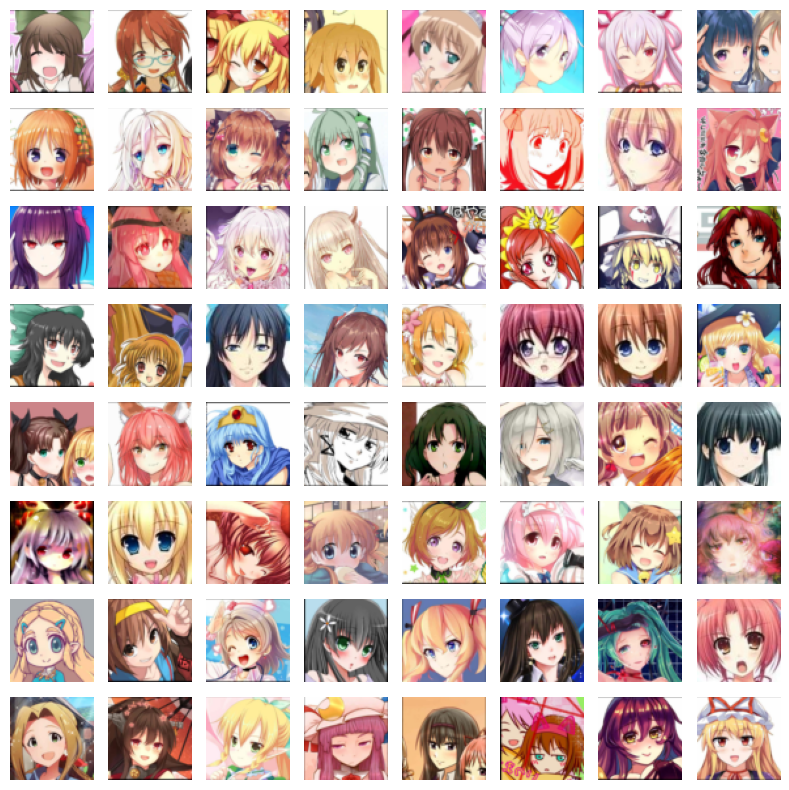

In [9]:
tensor_to_image = transforms.Compose([
    transforms.Lambda(lambda x: (x * 0.5 + 0.5).clamp(0, 1).cpu()),
    transforms.ToPILImage()
])
plot_images(next(iter(train_dataloader))[:64], 8, 8, process=tensor_to_image)

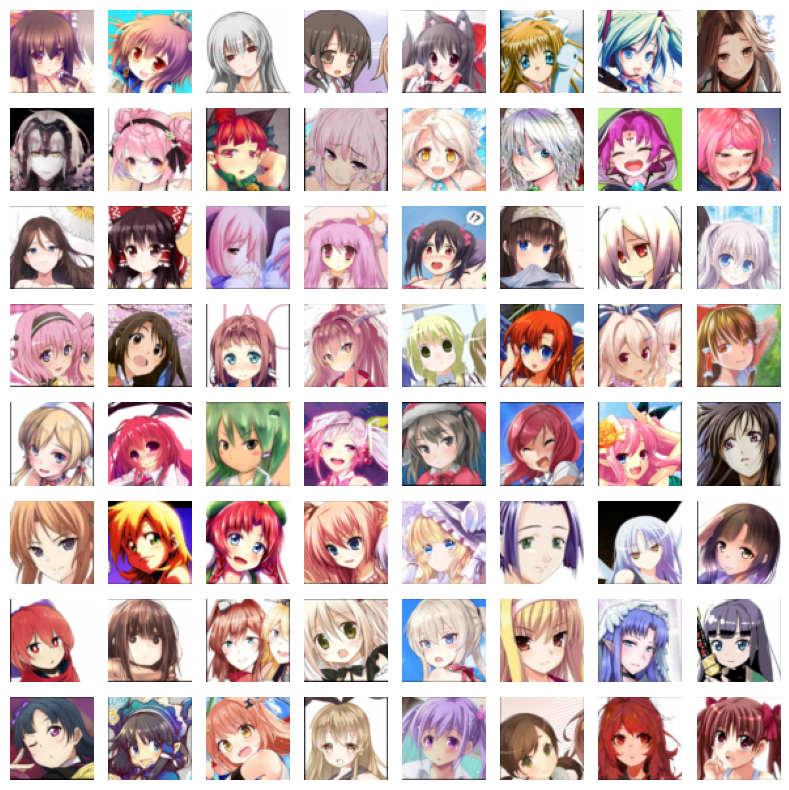

In [10]:
plot_images(next(iter(test_dataloader))[:64], 8, 8, process=tensor_to_image)

In [11]:
model = UNet2DModel(
    sample_size=64,
    in_channels=3,
    out_channels=3,
    layers_per_block=3,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
).to(device)

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100,
    eta_min=1e-5,
    last_epoch=-1
)

In [12]:
def save_model(save_path, model, optimizer, scheduler):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, save_path)

In [13]:
def load_model(load_path, model, optimizer, scheduler):
    saved_model = torch.load(load_path)

    model.load_state_dict(saved_model['model_state_dict'])
    optimizer.load_state_dict(saved_model['optimizer_state_dict'])
    scheduler.load_state_dict(saved_model['scheduler_state_dict'])


In [14]:
def train(model, noise_scheduler, optimizer, dataloader):
    model.train()
    losses = []
    for images in tqdm(dataloader, desc="Train batch", position=0, leave=False):
        batch_size = images.shape[0]
        images = images.to(model.device)

        noise = torch.randn_like(images)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size, )).long().to(model.device)
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample

        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return sum(losses) / len(losses)

In [15]:
@torch.no_grad()
def test(model, noise_scheduler, dataloader):
    model.eval()
    losses = []
    for images in tqdm(dataloader, desc="Test batch", position=0, leave=False):
        batch_size = images.shape[0]
        images = images.to(model.device)

        noise = torch.randn_like(images)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size, )).long().to(model.device)
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample

        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        losses.append(loss.item())

    return sum(losses) / len(losses)

In [16]:
@torch.no_grad()
def generate_image(model, noise_scheduler, batch_size=1):
    model.eval()
    sample_size = model.config.sample_size
    in_channels = model.config.in_channels

    images = torch.randn(batch_size, in_channels, sample_size, sample_size).to(model.device)
    for t in tqdm(noise_scheduler.timesteps):
        timesteps = t.unsqueeze(0).to(model.device)
        noise_pred = model(images, timesteps).sample

        scheduler_output = noise_scheduler.step(noise_pred, t, images)
        images = scheduler_output.prev_sample
    return images

In [17]:
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter


def train_loop(model, optimizer, scheduler, noise_scheduler, train_dataloader, test_dataloader, epochs=100):
    writer = SummaryWriter(log_dir=os.path.expanduser('~/logs'))

    train_losses = []
    test_losses = []
    lrs = []

    for epoch in range(epochs):
        print(f"{epoch} / {epochs}")

        train_loss = train(model, noise_scheduler, optimizer, train_dataloader)
        test_loss = test(model, noise_scheduler, test_dataloader)

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Test', test_loss, epoch)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        lrs.append(optimizer.param_groups[0]['lr'])
        try:
            scheduler.step()
        except RuntimeError:
            scheduler.step(test_loss)

        clear_output()
        plt.plot(train_losses, label="train")
        plt.plot(test_losses, label="test")
        plt.legend()
        plt.show()
        plt.plot(lrs, label="lr")
        plt.legend()
        plt.show()
        images = generate_image(model, noise_scheduler, batch_size=64)
        plot_images(images, 8, 8, process=tensor_to_image)

        transform = transforms.Compose([
            transforms.Lambda(lambda x: (x * 0.5 + 0.5).clamp(0, 1).cpu()),
            transforms.Resize(256, interpolation=InterpolationMode.NEAREST)
        ])
        images = list(map(transform, images))
        grid = make_grid(images, nrow=8)
        writer.add_image("Generated images", grid, epoch)

        writer.flush()
        save_model(os.path.expanduser(f'~/chkp/model_{epoch}.pth'), model, optimizer, scheduler)

    writer.close()

In [18]:
from collections import defaultdict
from termcolor import colored

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))


# Counting how many parameters does our model have
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = param.numel()
        if verbose_all or (verbose_only_learnable and param.requires_grad):
            print(
                colored(
                    '{: <65} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )

    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params

In [19]:
model_num_params(model)

conv_in.weight                                                    ~  1.728     params ~ grad: True
conv_in.bias                                                      ~  64        params ~ grad: True
time_embedding.linear_1.weight                                    ~  16.384    params ~ grad: True
time_embedding.linear_1.bias                                      ~  256       params ~ grad: True
time_embedding.linear_2.weight                                    ~  65.536    params ~ grad: True
time_embedding.linear_2.bias                                      ~  256       params ~ grad: True
down_blocks.0.resnets.0.norm1.weight                              ~  64        params ~ grad: True
down_blocks.0.resnets.0.norm1.bias                                ~  64        params ~ grad: True
down_blocks.0.resnets.0.conv1.weight                              ~  36.864    params ~ grad: True
down_blocks.0.resnets.0.conv1.bias                                ~  64        params ~ grad: True
down_block

(82918467, 82918467)

In [ ]:
train_loop(model, optimizer, scheduler, noise_scheduler, train_dataloader, test_dataloader)

0 / 100


Train batch:   2%|█▍                                                                                 | 82/4652 [01:36<1:30:22,  1.19s/it]

In [9]:
images = generate_image(model, noise_scheduler, 64)

100%|██████████| 1000/1000 [00:43<00:00, 23.17it/s]


In [11]:
plot_images(images, 8, 8, tensor_to_image)